<a href="https://colab.research.google.com/github/cmap/lincs-workshop-2020/blob/main/BQ_toolkit_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## cmapBQ Tutorial

This notebook is meant to show a few examples of exploring, selecting and retrieving data available within LINCS-CMap datasets from Google BigQuery.

`cmapBQ` allows for targeted retrieval of relevant gene expression data from the resources provided by The Broad Institute and LINCS Project

### Package installation

The cmapBQ package is available from `pip` and can be installed using the command below. Documentation is available on [Read The Docs](https://cmapbq.readthedocs.io/en/latest/)

In [4]:
!pip -q install cmapBQ

     |████████████████████████████████| 153kB 13.5MB/s 


### Standard Imports

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import requests

import matplotlib.pyplot as plt

### Credentials Setup and Package imports

Getting demo credentials from S3. To access BigQuery, a service account JSON credentials file must be obtained. Running the `cmap.config.setup_credentials(credentials_path)` function will point the toolkit to the credentials connected to your Google Account. 

More information about service accounts are available here: [Getting started with authentication](https://cloud.google.com/docs/authentication/getting-started)

In [2]:
import requests

# URL with credentials
url = ('https://s3.amazonaws.com/data.clue.io/api/bq_creds/BQ-demo-credentials.json')

response = requests.get(url)
credentials_filepath='/content/BQ-demo-credentials.json'

with open(credentials_filepath, 'w') as f:
  f.write(response.text)

Pointing cmapBQ to credentials file

In [6]:
import cmapBQ.query as cmap_query
import cmapBQ.config as cmap_config

# Set up credentials
cmap_config.setup_credentials(credentials_filepath)
bq_client = cmap_config.get_bq_client()

<div style="font-size: 10pt;line-height:30px">
    
Alternative method of authentication:

In [ ]:
#from google.cloud import bigquery
#os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_filepath
#bq_client = bigquery.Client()

# BigQuery Table Information

### The data hosted on BigQuery is organized in the following tables

<div style="font-size: 10pt;line-height:18px;font-weight:normal">
    
**compoundinfo:** <br> Metadata for all unique compounds included in the data release. Each row contains information about a unique compound such as MoA, target, etc. 
    
**instinfo:**  <br> Sample level metadata includes information for each replicate including experimental parameters such as timepoint and dose

**siginfo:**  <br> Signature (replicate collapsed) level 5 metadata. Includes experimental parameters such as timepoint and dose as well as metrics for bioactivity such as `tas` for [Transcriptional Activity Score](https://clue.io/connectopedia/signature_quality_metrics) and `cc_q75` for Replicate Correlation

**L1000 Level3:**  <br> Gene expression (GEX, Level 2) are normalized to invariant gene set curves and quantile normalized across each plate. Here, the data from each perturbagen treatment is referred to as a profile, experiment, or instance. Additional values for 11,350 additional genes not directly measured in the L10000 assay are inferred based on the normalized values for the 978 landmark genes.

    
**L1000 Level4:**  <br> Z-scores for each gene based on Level 3 with respect to the entire plate population. This comparison of profiles to their appropriate population control generates a list of differentially expressed genes.

**L1000 Level5:** <br> Replicate-collapsed z-score vectors based on Level 4. Replicate collapse generates one differential expression vector, which we term a signature. Connectivity analyses are performed on signatures.
    
**geneinfo:** <br> Metadata for gene_ids included in the data release. Each row contains mappings between gene_symbol, ensemble_id, gene_id as well as information about gene_type

**cellinfo:** <br> Metadata for cell lines included in the data release. Each row contains information such as cell_iname, ccle_name or cell_lineage

**genetic_pertinfo**: <br> Contains information related to genetic perturbagens such as type ['oe', 'sh', 'xpr'] and relevant gene_id, ensemble_id 


# Raw SQL Queries

`cmapBQ.query.list_tables()` function will display table adresses of default tables for usage in SQL queries

In [ ]:
import cmapBQ.query as cmap_query

cmap_query.list_tables()

cellinfo: cmap-big-table.cmap_lincs_public_views.cellinfo
compoundinfo: cmap-big-table.cmap_lincs_public_views.compoundinfo
geneinfo: cmap-big-table.cmap_lincs_public_views.geneinfo
genetic_pertinfo: cmap-big-table.cmap_lincs_public_views.genetic_pertinfo
instinfo: cmap-big-table.cmap_lincs_public_views.instinfo
level3: cmap-big-table.cmap_lincs_public_views.L1000_Level3
level4: cmap-big-table.cmap_lincs_public_views.L1000_Level4
level5: cmap-big-table.cmap_lincs_public_views.L1000_Level5
siginfo: cmap-big-table.cmap_lincs_public_views.siginfo


Raw SQL queries can be run on the public datasets as shown below. Syntax follows that of Google Biqquery, available here: https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax

### Example SQL Query 

In [ ]:
## This query may take up to a minute
query = "SELECT COUNT(DISTINCT(cid)) as num_level5_sigs FROM cmap-big-table.cmap_lincs_public_views.L1000_Level5"

cmap_query.run_query(query=query, client=bq_client).result().to_dataframe()

,num_level5_sigs
0,1165730


# cmapBQ Utilities

`cmapBQ` provides a multitude of utility functions to survey and retrieve data hosted on BigQuery. Below we will demonstrate a workflow for finding and analyzing data pertaining to an MoA of interest as an example.

# Get Table Schema Information

In [5]:
cmap_query.list_tables()

cellinfo: cmap-big-table.cmap_lincs_public_views.cellinfo
compoundinfo: cmap-big-table.cmap_lincs_public_views.compoundinfo
geneinfo: cmap-big-table.cmap_lincs_public_views.geneinfo
genetic_pertinfo: cmap-big-table.cmap_lincs_public_views.genetic_pertinfo
instinfo: cmap-big-table.cmap_lincs_public_views.instinfo
level3: cmap-big-table.cmap_lincs_public_views.L1000_Level3
level4: cmap-big-table.cmap_lincs_public_views.L1000_Level4
level5: cmap-big-table.cmap_lincs_public_views.L1000_Level5
siginfo: cmap-big-table.cmap_lincs_public_views.siginfo


In [6]:
cmap_query.get_table_info(bq_client, 'cmap-big-table.cmap_lincs_public_views.compoundinfo') 

,column_name,data_type
0,pert_id,STRING
1,cmap_name,STRING
2,target,STRING
3,moa,STRING
4,canonical_smiles,STRING
5,inchi_key,STRING
6,compound_aliases,STRING


In [ ]:
config = cmap_config.get_default_config()
compoundinfo_table = config.tables.compoundinfo

QUERY = ( 'SELECT moa, ' 
'COUNT(DISTINCT(pert_id)) AS count ' 
'FROM `{}` ' 
'GROUP BY moa')

QUERY = QUERY.format(compoundinfo_table)
cmap_query.run_query(QUERY, bq_client).result().to_dataframe()

,moa,count
0,None,31262
1,CAR agonist,2
2,ALK inhibitor,7
3,Akt inhibitor,13
4,BCL inhibitor,11
...,...,...
653,Telomerase reverse transcriptase expression in...,1
654,Gonadotropin releasing factor hormone receptor...,2
655,Gonadotropin releasing factor hormone receptor...,1
656,"Precursor for food preservatives, plasticizers...",1


### Metadata at a glance

In [ ]:
moas = cmap_query.list_cmap_moas(bq_client)
display(moas)

,moa
0,None
1,CAR agonist
2,ALK inhibitor
3,Akt inhibitor
4,BCL inhibitor
...,...
653,Telomerase reverse transcriptase expression in...
654,Gonadotropin releasing factor hormone receptor...
655,Gonadotropin releasing factor hormone receptor...
656,"Precursor for food preservatives, plasticizers..."


In [8]:
targets = cmap_query.list_cmap_targets(bq_client)
display(targets.sort_values('count'))

,target,count
890,RAB9A,1
285,SOAT2,1
284,SOAT1,1
283,ACACB,1
282,ACACA,1
...,...,...
75,PTGS2,78
94,HTR2A,79
141,NR3C1,90
77,DRD2,95


In [ ]:
display(
    moas[moas['moa'].str.contains('Glucocorticoid receptor agonist', na=False)]
)
display(
    targets[targets['target'].str.contains('EGFR', na=False)]
)

,moa
479,Glucocorticoid receptor agonist


,target
31,EGFR


# Compound Information Table

<div style="font-size: 12pt;line-height:20px">

If the desired target or MoA is present, we can then query the compound table to get information about what compounds may relate to that MoA

In [ ]:
moa = 'Glucocorticoid receptor agonist'
#moa = 'EGFR inhibitor'

moa_cpinfo = cmap_query.cmap_compounds(client=bq_client,
  moa=moa, 
  #verbose=True,
)
moa_cpinfo.sample(10)

,pert_id,cmap_name,target,moa,canonical_smiles,inchi_key,compound_aliases
12,BRD-K39188321,betamethasone,NR3C1,Glucocorticoid receptor agonist,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...,UREBDLICKHMUKA-DVTGEIKXSA-N,None
53,BRD-K71451869,halcinonide,NR3C1,Glucocorticoid receptor agonist,CC1(C)O[C@@H]2C[C@H]3[C@H]4CCC5=CC(=O)CC[C@]5(...,MUQNGPZZQDCDFT-VDJZZIFASA-N,None
67,BRD-K13688115,medrysone,NR3C1,Glucocorticoid receptor agonist,C[C@H]1C[C@H]2[C@H]3CC[C@H](C(C)=O)[C@@]3(C)C[...,GZENKSODFLBBHQ-WXWRWIGRSA-N,None
73,BRD-K87990216,piretanide,SLC12A2,Glucocorticoid receptor agonist,NS(=O)(=O)c1cc(cc(N2CCCC2)c1Oc1ccccc1)C(O)=O,UJEWTUDSLQGTOA-UHFFFAOYSA-N,None
58,BRD-K73978287,hydrocortisone,NR3C1,Glucocorticoid receptor agonist,C[C@@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@...,VWQWXZAWFPZJDA-VDINROJTSA-N,None
9,BRD-K76747609,beclometasone,NR3C1,Glucocorticoid receptor agonist,CCC(=O)OCC(=O)[C@@]1(OC(=O)CC)[C@@H](C)C[C@H]2...,KUVIULQEHSCUHY-YFYIJNNCSA-N,None
72,BRD-K87990216,piretanide,SLC12A1,Glucocorticoid receptor agonist,NS(=O)(=O)c1cc(cc(N2CCCC2)c1Oc1ccccc1)C(O)=O,UJEWTUDSLQGTOA-UHFFFAOYSA-N,None
1,BRD-K60640630,mometasone,NR3C1,Glucocorticoid receptor agonist,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,WOFMFGQZHJDGCX-ZULDAHANSA-N,None
5,BRD-K45149020,amcinonide,NR3C1,Glucocorticoid receptor agonist,CC(=O)OCC(=O)[C@@]12OC3(CCCC3)O[C@@H]1C[C@H]1[...,ILKJAFIWWBXGDU-KNPIAJNZSA-N,None
78,BRD-A62525898,prednisone,NR3C1,Glucocorticoid receptor agonist,C[C@]12CC(=O)C3C(CCC4=CC(=O)C=C[C@]34C)C1CC[C@...,XOFYZVNMUHMLCC-BDQMTFAOSA-N,None


<div style="font-size: 12pt;line-height:20px">

Lets take the first 10 compounds and see how many signatures are available for those compounds. We can pass a list of compounds to the **cmap_sig function**, which then queries the dataset for compounds that match.

In [ ]:
moa_cps = moa_cpinfo.cmap_name.unique()
moa_cps[0:10]

array(['dexamethasone', 'mometasone', 'flumetasone', 'alclometasone',
       'amcinonide', 'beclometasone', 'beclomethasone-dipropionate',
       'betamethasone', 'betamethasone-acetate', 'betamethasone-valerate'],
      dtype=object)

# Cell Line information

In [ ]:
core_cell_lines = ['A375', 'A549', 'HCC515', 'HEPG2', 'MCF7', 'PC3', 'VCAP', 'HT29', 'HA1E']

core_cellinfo = cmap_query.cmap_cell(bq_client, 
  cell_iname=core_cell_lines, 
  verbose=True,
)
core_cellinfo.head(10)

Table: 
 cmap-big-table.cmap_lincs_public_views.cellinfo
Query:
 SELECT * FROM cmap-big-table.cmap_lincs_public_views.cellinfo WHERE cell_iname in UNNEST(['A375', 'A549', 'HCC515', 'HEPG2', 'MCF7', 'PC3', 'VCAP', 'HT29', 'HA1E'])


,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
0,HCC515,CVCL_5136,None,None,None,None,None,None,None,tumor,Unknown,F,Unknown,lung,lung cancer,carcinoma,None,adherent,HCC515_LUNG,HCC0515
1,HA1E,None,None,None,None,60,MEM-ALPHA (Invitrogen A1049001) supplemented w...,None,None,normal,Unknown,Unknown,Unknown,kidney,normal kidney sample,normal kidney sample,None,unknown,HA1E_KIDNEY,None
2,A549,CVCL_0023,58,None,None,48,F-12K ATCC catalog # 3-24,CCL-185,c-4,tumor,Caucasian,M,Primary,lung,lung cancer,non small cell carcinoma,ATCC,adherent,A549_LUNG,A 549
3,A375,CVCL_0132,54,None,None,36,DMEM Invitrogen catalog # 11995-65,CRL-1619,c-127,tumor,Unknown,F,Metastatic,skin,skin cancer,melanoma,ATCC,adherent,A375_SKIN,A 375|A-375
4,HT29,CVCL_0320,44,None,None,36,McCoy's 5A Invitrogen catalog # 166-82,HTB-38,c-272,tumor,Caucasian,F,Primary,large_intestine,colon cancer,adenocarcinoma,ATCC,adherent,HT29_LARGE_INTESTINE,HT 29
5,HEPG2,CVCL_0027,15,None,None,84,EMEM ATCC catalog # 3-23,HB-8065,None,tumor,Caucasian,M,Primary,liver,liver cancer,carcinoma,ATCC,adherent,HEPG2_LIVER,Hep G2|HEP-G2
6,MCF7,CVCL_0031,40,None,None,72,EMEM ATCC catalog # 3-23,HTB-22,c-438,tumor,Caucasian,F,Metastatic,breast,breast cancer,adenocarcinoma,ATCC,adherent,MCF7_BREAST,IBMF-7
7,PC3,CVCL_0035,62,None,None,72,F-12K ATCC catalog # 3-24,CRL-1435,c-214,tumor,Caucasian,M,Metastatic,prostate,prostate cancer,adenocarcinoma,ATCC,mix,PC3_PROSTATE,PC.3|PC-3
8,VCAP,CVCL_2235,None,None,None,220,DMEM ATCC catalog # 3-22,None,None,tumor,Caucasian,M,Metastatic,prostate,prostate cancer,adenocarcinoma,ATCC,adherent,VCAP_PROSTATE,Vcap


# Query Siginfo 

<div style="font-size: 12pt;line-height:20px">


The siginfo file provides information on the conditions for each experiment such as compound, dose, timepoint, cell line, and more.

The table also includes information regarding the signal strength and replicate correlation of the compound. The `tas` contains the signatures **Transcriptional Activity Score (TAS)** which is an aggregate measure of strength and reproducibilty.  [More information about signature quality metrics can be found on Connectopedia](https://clue.io/connectopedia/signature_quality_metrics)

In [ ]:
sample_cell_lines = list(core_cellinfo.cell_iname.unique()) #core_cell_lines

sample_compounds = list(moa_cps[0:10])
print("Compounds: {}".format(sample_compounds))
print("Cell Lines: {}".format(sample_cell_lines))

siginfo_sample = cmap_query.cmap_sig(     #Query the siginfo table
    bq_client, 
    cmap_name = sample_compounds,
    cell_iname = sample_cell_lines,
    return_fields = 'all'
)

siginfo_sample_filtered = siginfo_sample.loc[     #Filter returned table 
    (siginfo_sample.nsample >= 3) &
    (siginfo_sample.pert_dose >= 10) &
    (siginfo_sample.pert_itime.eq('24 h'))
]


siginfo_sample_filtered = siginfo_sample_filtered.merge(core_cellinfo, on='cell_iname') #join with cellinfo table to get cell lineage information
siginfo_sample_filtered.sample(5)

Compounds: ['dexamethasone', 'mometasone', 'flumetasone', 'alclometasone', 'amcinonide', 'beclometasone', 'beclomethasone-dipropionate', 'betamethasone', 'betamethasone-acetate', 'betamethasone-valerate']
Cell Lines: ['HCC515', 'HA1E', 'A549', 'A375', 'HT29', 'HEPG2', 'MCF7', 'PC3', 'VCAP']


,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,nsample,cc_q75,ss_ngene,tas,pct_self_rank_q25,wt,median_recall_rank_spearman,median_recall_rank_wtcs_50,median_recall_score_spearman,median_recall_score_wtcs_50,batch_effect_tstat,batch_effect_tstat_pct,is_hiq,qc_pass,pert_id,sig_id,pert_type,cell_iname,id,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
89,b3,10.0,10.0,uM,10 uM,24 h,24.0,h,PC3,BRD-K61496577,5,0.13,220,0.171007,5.399570,"""""",15.48170,5.509010,0.063123,0.411144,25.09,87.7692,0,0,BRD-K61496577,CPC003_PC3_24H:BRD-K61496577-001-03-8:10,trt_cp,PC3,None,L09,CPC003_PC3_24H_X1_B3_DUO52HI53LO|CPC003_PC3_24...,CPC003_PC3_24H_X1_B3_DUO52HI53LO:L09|CPC003_PC...,None,CPC,flumetasone,CVCL_0035,62,None,None,72,F-12K ATCC catalog # 3-24,CRL-1435,c-214,tumor,Caucasian,M,Metastatic,prostate,prostate cancer,adenocarcinoma,ATCC,mix,PC3_PROSTATE,PC.3|PC-3
112,b3,10.0,10.0,uM,10 uM,24 h,24.0,h,HT29,BRD-A35108200,4,0.20,70,0.119645,5.483210,"""""",10.35870,11.993400,0.134203,0.365652,9.22,38.1281,0,1,BRD-A35108200,CPC006_HT29_24H:BRD-A35108200-001-04-7:10,trt_cp,HT29,None,F09,CPC006_HT29_24H_X1_B3_DUO52HI53LO|CPC006_HT29_...,CPC006_HT29_24H_X1_B3_DUO52HI53LO:F09|CPC006_H...,None,CPC,dexamethasone,CVCL_0320,44,None,None,36,McCoy's 5A Invitrogen catalog # 166-82,HTB-38,c-272,tumor,Caucasian,F,Primary,large_intestine,colon cancer,adenocarcinoma,ATCC,adherent,HT29_LARGE_INTESTINE,HT 29
1,b3,10.0,10.0,uM,10 uM,24 h,24.0,h,A375,BRD-A69951442,5,0.35,198,0.266193,0.169972,"""""",3.33683,0.908281,0.266865,0.532617,13.76,60.3503,1,1,BRD-A69951442,CPC006_A375_24H:BRD-A69951442-001-01-3:10,trt_cp,A375,None,O03,CPC006_A375_24H_X1_B3_DUO52HI53LO|CPC006_A375_...,CPC006_A375_24H_X1_B3_DUO52HI53LO:O03|CPC006_A...,None,CPC,dexamethasone,CVCL_0132,54,None,None,36,DMEM Invitrogen catalog # 11995-65,CRL-1619,c-127,tumor,Unknown,F,Metastatic,skin,skin cancer,melanoma,ATCC,adherent,A375_SKIN,A 375|A-375
66,b4,10.0,10.0,uM,10 uM,24 h,24.0,h,MCF7,BRD-A92177080,5,0.16,99,0.127265,10.940900,"""""",37.89950,15.401000,0.038437,0.395826,24.78,87.3672,0,1,BRD-A92177080,CPC015_MCF7_24H:BRD-A92177080-001-01-3:10,trt_cp,MCF7,None,B09,CPC015_MCF7_24H_X1_B4_DUO52HI53LO|CPC015_MCF7_...,CPC015_MCF7_24H_X1_B4_DUO52HI53LO:B09|CPC015_M...,None,CPC,betamethasone-acetate,CVCL_0031,40,None,None,72,EMEM ATCC catalog # 3-23,HTB-22,c-438,tumor,Caucasian,F,Metastatic,breast,breast cancer,adenocarcinoma,ATCC,adherent,MCF7_BREAST,IBMF-7
58,b4,10.0,10.0,uM,10 uM,24 h,24.0,h,MCF7,BRD-A90131694,5,0.07,100,0.084602,27.133500,"""""",38.93730,29.240400,0.043602,0.279774,24.78,87.3672,0,1,BRD-A90131694,CPC015_MCF7_24H:BRD-A90131694-001-02-8:10,trt_cp,MCF7,None,N23,CPC015_MCF7_24H_X1_B4_DUO52HI53LO|CPC015_MCF7_...,CPC015_MCF7_24H_X1_B4_DUO52HI53LO:N23|CPC015_M...,None,CPC,alclometasone,CVCL_0031,40,None,None,72,EMEM ATCC catalog # 3-23,HTB-22,c-438,tumor,Caucasian,F,Metastatic,breast,breast cancer,adenocarcinoma,ATCC,adherent,MCF7_BREAST,IBMF-7


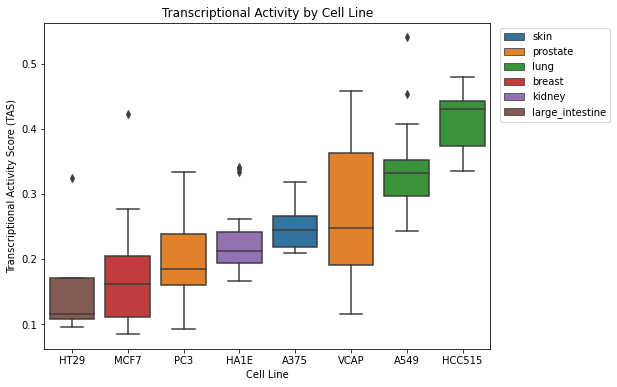

In [ ]:
plt.figure(figsize=(8,6))

sorted_index = siginfo_sample_filtered.groupby('cell_iname').median().sort_values('tas').index

sns.boxplot(
    data=siginfo_sample_filtered,
    x='cell_iname',
    y='tas',
    hue='cell_lineage',
    dodge=False,
    order=sorted_index
);

plt.title('Transcriptional Activity by Cell Line')
plt.xlabel('Cell Line')
plt.ylabel('Transcriptional Activity Score (TAS)')
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
plt.show()

# Numerical Data

## Landmark Genespace

In [ ]:
import requests

# URL with credentials
url = ('https://s3.amazonaws.com/data.clue.io/api/bq_creds/lm_epsilon_gene_ids_n978.grp')

response = requests.get(url)
lm_grp='/content/lm_epsilon_gene_ids_n978.grp'

with open(lm_grp, 'w') as f:
  f.write(response.text)

In [ ]:
from cmapPy.set_io import grp
lm_gene_ids = grp.read(lm_grp)

In [ ]:
len(siginfo_sample_filtered)

129

## Extracting Numerical data using `cmapBQ.query.cmap_matrix`

In [ ]:
sig_ids = siginfo_sample_filtered.sig_id.unique() #sig_ids are unique for each signature and relates siginfo table to numerical data

sample_data_numerical = cmap_query.cmap_matrix(bq_client,
    data_level='level5',
    cid=list(sig_ids), #columns are signatures
    rid=lm_gene_ids, #subset to L1000 space #rows are features (genes)
)

print( sample_data_numerical.data_df.shape )

Running query ... (1/1)
Pivoting Dataframes to GCT objects
Pivoting... (1/1)
Complete
(978, 129)


`cmap_matrix` returns a GCToo object, part of the cmapPy resource. Documentation on the GCToo object structure and useful cmapPy utilities can be found in the cmapPy documentation here: https://cmappy.readthedocs.io/en/stable/

### Write to file as GCTX

In [ ]:
from cmapPy.pandasGEXpress.write_gctx import write as write_gctx
from cmapPy.pandasGEXpress.write_gct import write as write_gct

#write_gctx(sample_data_numerical, filename)
#write_gct(sample_data_numerical, filename)

## Pairwise Correlations

In [ ]:
corr_matrix = sample_data_numerical.data_df.corr()
print(corr_matrix.shape)

(129, 129)


### Function definitions

In [ ]:
import scipy
import scipy.cluster.hierarchy as sch
import numpy as np


def get_off_diagonals(matrix):
  """
  Extract off-diagonal elements of matrix as list of values

  Parameters
  ----------
  matrix: pandas.DataFrame or numpy.ndarray, NxN matrix
  
  Returns
  -------
  """
  return matrix.where(
    np.triu(np.ones(matrix.shape).astype(bool), k=1)
  ).stack().reset_index(drop=True)

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

def get_subplot_dimensions(num_plots):
  if num_plots % 4 == 0:
    return num_plots//4, 4
  elif num_plots % 3 == 0:
    return num_plots//3, 3
  elif num_plots % 2 == 0:
    return num_plots//2, 2
  elif num_plots % 1 == 0:
    return num_plots//1, 1


In [ ]:
clustered_matrix = cluster_corr(sample_data_numerical.data_df.corr())

### Histograms

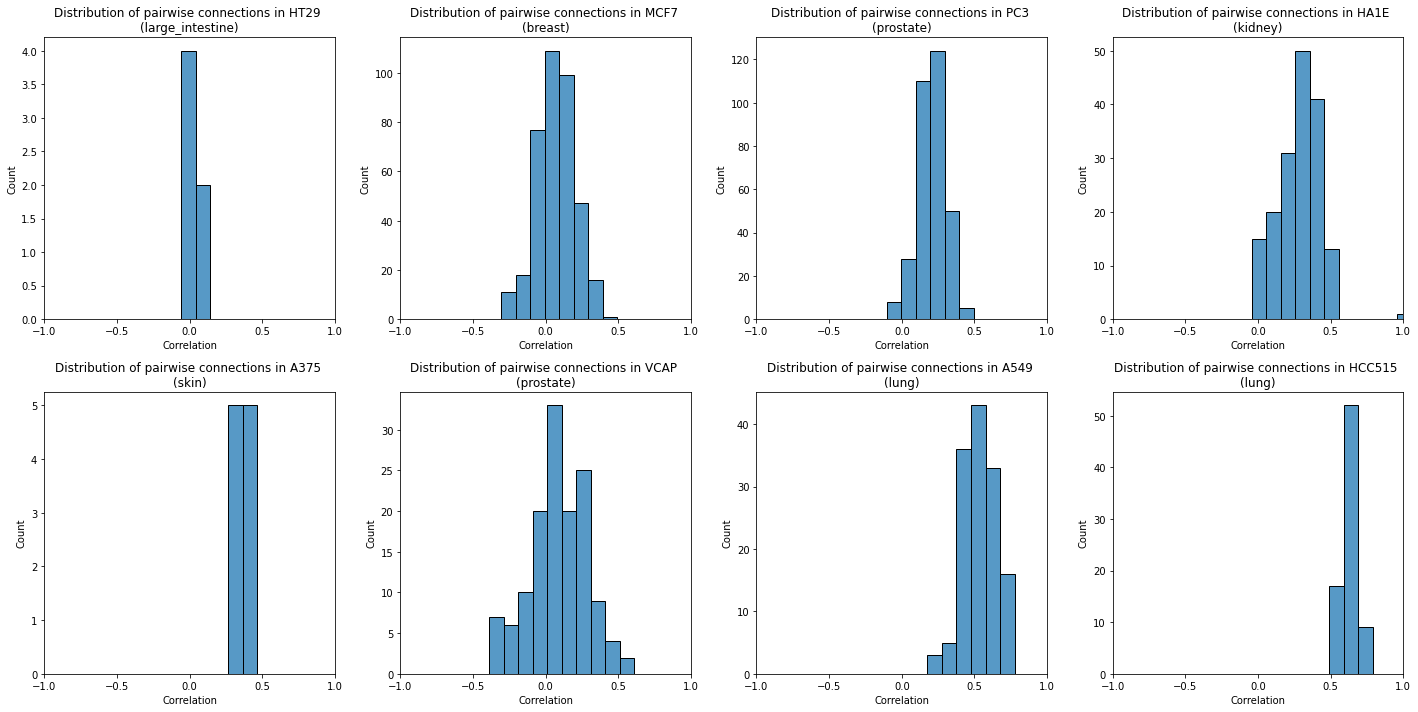

In [ ]:
#Lists used for sns.boxplot
dist_list = []
cell_list = siginfo_sample_filtered.groupby('cell_iname').median().sort_values('tas').index

lineage_list = []

#ncols=4
#nrows=2
subplot_size = 5
nrows, ncols = get_subplot_dimensions(len(cell_list))
fig_dist, axes_dist = plt.subplots(nrows, ncols, figsize=(subplot_size*ncols,subplot_size*nrows))


for i,cell in enumerate(cell_list):

  lineage = core_cellinfo.loc[
        core_cellinfo.cell_iname.eq(cell)
      ].cell_lineage.unique()[0]  #Lineage information for cell line

  cell_sig_ids = siginfo_sample_filtered.loc[
    siginfo_sample_filtered.cell_iname.eq(cell)
  ].sig_id.unique()  #Get sig_ids for cell line

  cell_corrs = corr_matrix.loc[cell_sig_ids, cell_sig_ids] #Extract correlations for cell line
  cell_corrs = cluster_corr(cell_corrs) #Cluster cell correlations
  
  dist = get_off_diagonals(cell_corrs) #Extract off-diagonals
  
  dist_list.append(dist)
  lineage_list.append(lineage)

  sns.histplot(dist, 
               binwidth=0.1,
               ax=axes_dist[i // ncols][i % ncols])
  axes_dist[i // ncols][i % ncols].set_title(
    'Distribution of pairwise connections in {} \n({})'.format(
        cell, 
        lineage
      )
    )
  axes_dist[i // ncols][i % ncols].set_xlim(-1, 1)
  axes_dist[i // ncols][i % ncols].set_xlabel('Correlation')
  axes_dist[i // ncols][i % ncols].set_xticks([-1, -0.5, 0, 0.5, 1])

plt.tight_layout()
plt.show()

### Boxplots

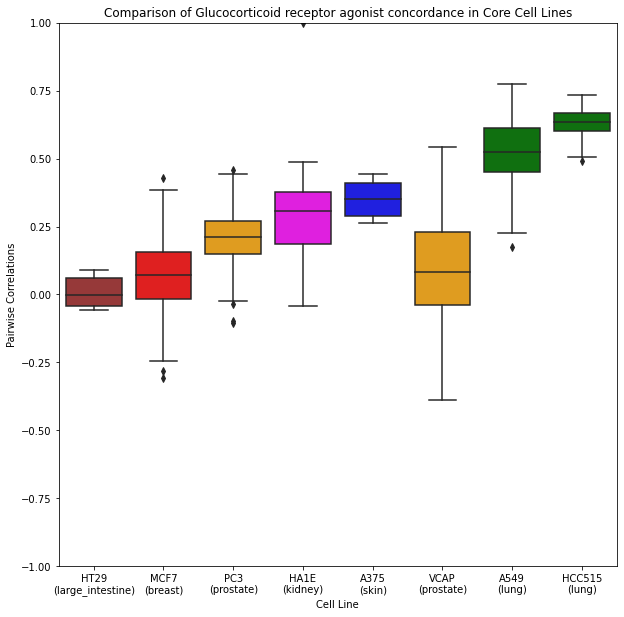

In [ ]:
plt.figure(figsize=(10,10))
colors_list = ['brown', 'red', 'orange', 'magenta', 'blue', 'orange', 'green', 'green'] #manual coloring by cell_lineage

sns.boxplot(data=dist_list, palette=colors_list)

labels = ['{}\n({})'.format(cell_list[i], lineage_list[i]) for i in range(0,len(cell_list))]
plt.xticks(np.linspace(0,7, 8), labels)

plt.ylabel('Pairwise Correlations')
plt.xlabel('Cell Line')
plt.ylim([-1,1])
plt.title('Comparison of {} concordance in Core Cell Lines'.format(moa))
plt.show()

### Heatmaps

#### Color Map Configuration

In [ ]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

red_blue_map = cm.get_cmap('RdBu_r', 256)
tau_red_blue_90 = red_blue_map(np.linspace(0,1,200))
white = np.array([1, 1, 1, 1])
tau_red_blue_90[70:130, :] = white
tau_red_blue_90 = ListedColormap(tau_red_blue_90)

#### Full Correlation Matrix

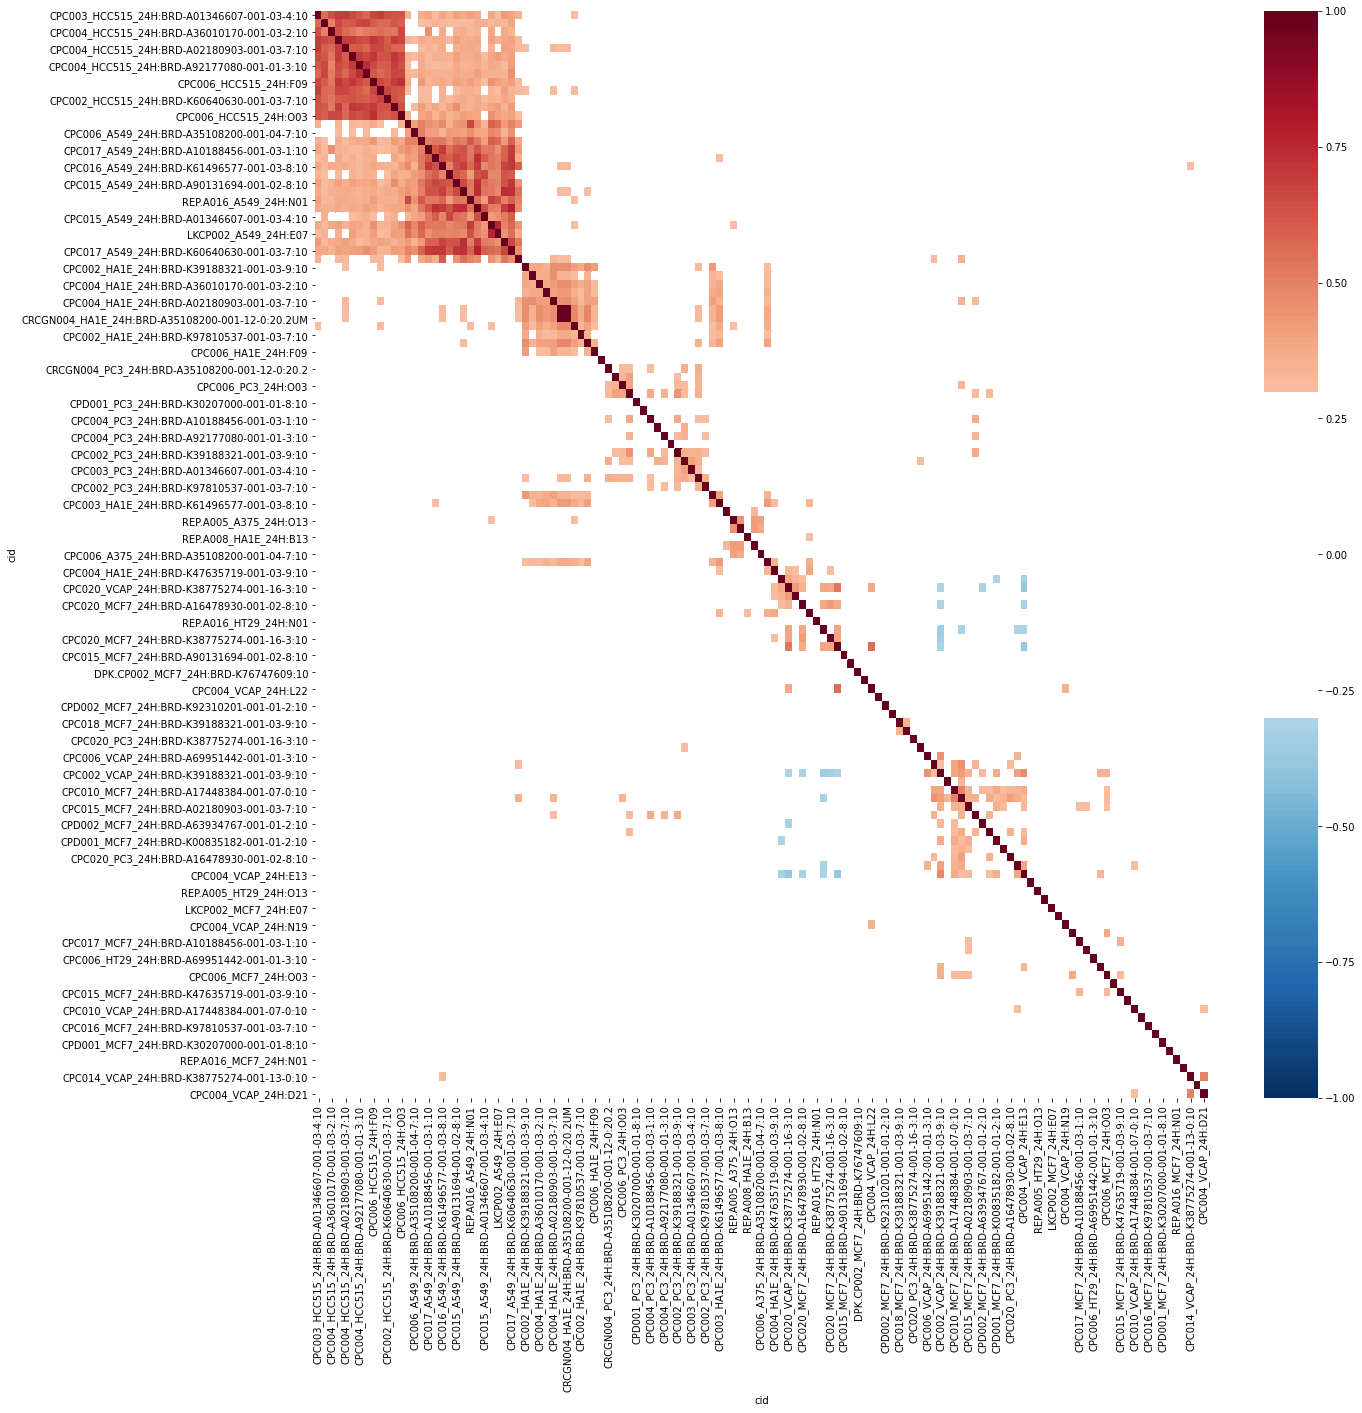

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(clustered_matrix, cmap=tau_red_blue_90, vmin=-1, vmax=1)
plt.show()

#### Pairwise correlations by Cell Line

In [7]:
cell_list = siginfo_sample_filtered.groupby('cell_iname').median().sort_values('tas').index #sorted by median tas

nrows, ncols = get_subplot_dimensions(len(cell_list))
subplot_size = 5
fig_hm, axes_hm = plt.subplots(nrows, ncols, figsize=(subplot_size*ncols*1.4,subplot_size*nrows))

for i,cell in enumerate(cell_list):

  lineage = core_cellinfo.loc[
          core_cellinfo.cell_iname.eq(cell)
        ].cell_lineage.unique()[0]

  cell_siginfo = siginfo_sample_filtered.loc[
    siginfo_sample_filtered.cell_iname.eq(cell)
  ]

  cell_sig_ids = cell_siginfo.sig_id.unique()  
  
  cell_corrs = corr_matrix.loc[cell_sig_ids, cell_sig_ids]

  cell_corrs = cluster_corr(cell_corrs)

  cell_siginfo.set_index('sig_id').loc[cell_corrs.columns] #sort to match clustered matrix
  
  sns.heatmap(cell_corrs,
              cmap=tau_red_blue_90, 
              vmin=-1, 
              vmax=1,
              ax=axes_hm[i // ncols][i % ncols])
  
  axes_hm[i // ncols][i % ncols].set_xticklabels([]) 
  axes_hm[i // ncols][i % ncols].set_yticklabels(cell_siginfo.cmap_name) # Add compound names
  axes_hm[i // ncols][i % ncols].set_xlabel('')
  axes_hm[i // ncols][i % ncols].set_ylabel('')
  axes_hm[i // ncols][i % ncols].set_title('Cell Line: {}\n Cell Lineage: {}'.format(cell, lineage))

plt.tight_layout()


NameError: ignored